# Downloading and Initializing Data

In [6]:
#!/bin/bash
!kaggle datasets download dnepozitek/maryland-polyvore-images

Dataset URL: https://www.kaggle.com/datasets/dnepozitek/maryland-polyvore-images
License(s): unknown
100% 12.8G/12.8G [01:14<00:00, 214MB/s]
100% 12.8G/12.8G [01:14<00:00, 184MB/s]


In [1]:
import os
import zipfile

In [2]:
# Specify the path to the zip file
zip_file_path = '/content/maryland-polyvore-images.zip'
extract_to = '/content/maryland_polyvore'

In [3]:
# Create a folder to extract the zip file
os.makedirs(extract_to, exist_ok=True)

In [7]:
# Extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print("File extracted successfully!")

File extracted successfully!


# Handling Dependencies

In [8]:
import torch
print('PyTorch version:', torch.__version__)
print('CUDA version:', torch.version.cuda)

PyTorch version: 2.5.0+cu121
CUDA version: 12.1


In [21]:
# Install PyTorch Geometric dependencies
!pip install --verbose --no-cache-dir torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-2.0.0+cu118.html

Using pip 24.1.2 from /usr/local/lib/python3.10/dist-packages/pip (python 3.10)
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu118.html


In [10]:
# Set device to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [11]:
# Check GPU type
gpu_info = !nvidia-smi --query-gpu=name --format=csv,noheader
print(f"GPU type: {gpu_info[0]}")

GPU type: NVIDIA A100-SXM4-40GB


# Data HandlingLibraries

In [12]:
import os
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from PIL import Image, UnidentifiedImageError  # To handle corrupted images
import numpy as np
import pandas as pd

# Data Handling

In [13]:
# Directory where all user folders are located
base_dir = '/content/maryland_polyvore/images/'

# Create lists to store user IDs and item paths
user_ids = []
item_paths = []

# Loop through each user directory
for user_dir in os.listdir(base_dir):
    user_path = os.path.join(base_dir, user_dir)

    # Ensure we are processing directories
    if os.path.isdir(user_path):
        # Loop through each image (item) in the user's directory
        for item in os.listdir(user_path):
            item_path = os.path.join(user_path, item)

            # Store user ID (directory name) and item path
            user_ids.append(user_dir)
            item_paths.append(item_path)

# Create a DataFrame with two columns: User_ID and Item_Path
df = pd.DataFrame({'User_ID': user_ids, 'Item_Path': item_paths})

# Display the DataFrame
df.head()

# If you want to save this DataFrame for later use:
df.to_csv('/content/maryland_polyvore/user_item_data.csv', index=False)

In [14]:
df

,User_ID,Item_Path
0,194700985,/content/maryland_polyvore/images/194700985/10...
1,194700985,/content/maryland_polyvore/images/194700985/4.jpg
2,194700985,/content/maryland_polyvore/images/194700985/5.jpg
3,194700985,/content/maryland_polyvore/images/194700985/1.jpg
4,194700985,/content/maryland_polyvore/images/194700985/6.jpg
...,...,...
444366,198611407,/content/maryland_polyvore/images/198611407/6.jpg
444367,198611407,/content/maryland_polyvore/images/198611407/2.jpg
444368,198611407,/content/maryland_polyvore/images/198611407/0.jpg
444369,198611407,/content/maryland_polyvore/images/198611407/7.jpg


# Feature Extraction

In [15]:
# GPU setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [16]:
# Define custom Dataset to handle loading images and their paths
class PolyvoreDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['Item_Path']
        try:
            image = Image.open(img_path).convert('RGB')  # Ensure the image is in RGB format
        except (OSError, UnidentifiedImageError) as e:
            print(f"Error loading image {img_path}: {e}")
            return None, None, None  # Return None for corrupted images

        if self.transform:
            image = self.transform(image)
        user_id = self.dataframe.iloc[idx]['User_ID']
        return image, user_id, img_path

In [17]:
# Define image transformations: Resizing and normalizing based on ImageNet dataset
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet50 input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
])

In [18]:
# Load the ResNet50 model without the fully connected layer (feature extraction)
model = models.resnet50(pretrained=True)
model = torch.nn.Sequential(*list(model.children())[:-1])  # Remove the last classification layer
model.eval()  # Set model to evaluation mode
model.to(device)  # Move model to GPU

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 203MB/s]


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [19]:
# Set the batch size and chunk size for processing
batch_size = 32  # You can adjust this based on your GPU memory capacity
chunk_size = 1000  # Number of images to process in each chunk

# Directory to save the extracted features
features_dir = '/content/maryland_polyvore/features/'
os.makedirs(features_dir, exist_ok=True)

# Load the original user-item dataframe
df = pd.read_csv('/content/maryland_polyvore/user_item_data.csv')

In [20]:
# DataLoader for batch processing
def get_data_loader(df_chunk, batch_size):
    dataset = PolyvoreDataset(df_chunk, transform=image_transform)

    # Filter out the NoneType before sending to the DataLoader
    def collate_fn(batch):
        batch = list(filter(lambda x: x[0] is not None, batch))  # Keep only valid images
        if len(batch) == 0:
            return None, None, None
        images, user_ids, img_paths = zip(*batch)
        return torch.stack(images), user_ids, img_paths

    return DataLoader(dataset, batch_size=batch_size, shuffle=False, pin_memory=True, collate_fn=collate_fn)

In [21]:
# Function to extract and save features in chunks
def extract_features_in_chunks(df, model, chunk_size, batch_size, save_dir):
    num_chunks = len(df) // chunk_size + 1

    for i in range(num_chunks):
        start_idx = i * chunk_size
        end_idx = min((i + 1) * chunk_size, len(df))
        df_chunk = df.iloc[start_idx:end_idx]

        print(f"Processing chunk {i + 1}/{num_chunks}, images {start_idx} to {end_idx}")

        # DataLoader for the current chunk
        data_loader = get_data_loader(df_chunk, batch_size)

        all_features = []  # To store extracted features
        all_paths = []     # To store image paths

        # Extract features for each batch
        for images, user_ids, img_paths in data_loader:
            if images is None:
                continue  # Skip empty batches (due to all images being invalid)

            images = images.to(device)  # Move images to GPU

            with torch.no_grad():
                features = model(images).squeeze().cpu().numpy()  # Extract features, move to CPU

            all_features.append(features)
            all_paths.extend(img_paths)

        # Concatenate all features in this chunk
        if len(all_features) > 0:  # Ensure we have data to save
            all_features = np.vstack(all_features)

            # Save the features to a .npy file
            features_file = os.path.join(save_dir, f'features_chunk_{i + 1}.npy')
            np.save(features_file, all_features)
            print(f"Saved features to {features_file}")

            # Save the image paths for reference
            paths_file = os.path.join(save_dir, f'paths_chunk_{i + 1}.csv')
            pd.DataFrame({'Image_Path': all_paths}).to_csv(paths_file, index=False)
            print(f"Saved paths to {paths_file}")

        # Clear memory after processing each chunk
        torch.cuda.empty_cache()

In [22]:
# Call the function to start feature extraction
extract_features_in_chunks(df, model, chunk_size, batch_size, features_dir)

Processing chunk 1/445, images 0 to 1000
Saved features to /content/maryland_polyvore/features/features_chunk_1.npy
Saved paths to /content/maryland_polyvore/features/paths_chunk_1.csv
Processing chunk 2/445, images 1000 to 2000
Saved features to /content/maryland_polyvore/features/features_chunk_2.npy
Saved paths to /content/maryland_polyvore/features/paths_chunk_2.csv
Processing chunk 3/445, images 2000 to 3000
Saved features to /content/maryland_polyvore/features/features_chunk_3.npy
Saved paths to /content/maryland_polyvore/features/paths_chunk_3.csv
Processing chunk 4/445, images 3000 to 4000
Saved features to /content/maryland_polyvore/features/features_chunk_4.npy
Saved paths to /content/maryland_polyvore/features/paths_chunk_4.csv
Processing chunk 5/445, images 4000 to 5000
Saved features to /content/maryland_polyvore/features/features_chunk_5.npy
Saved paths to /content/maryland_polyvore/features/paths_chunk_5.csv
Processing chunk 6/445, images 5000 to 6000
Saved features to /

# Loading Features and Preparing Data

In [1]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from torch_geometric.data import Data
from torch_geometric.nn import SAGEConv

/usr/local/lib/python3.10/dist-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /usr/local/lib/python3.10/dist-packages/torch_scatter/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/usr/local/lib/python3.10/dist-packages/torch_geometric/typing.py:97: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: /usr/local/lib/python3.10/dist-packages/torch_cluster/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-cluster'. "
/usr/local/lib/python3.10/dist-packages/torch_geometric/typing.py:113: UserWarning: An issue occurred while importing 'torch-spline-conv'. Disabling its usage. Stacktrace: /usr/local/lib/python3.10/dist-packages/torch_spline_conv/_version_cuda.so: undefined symbol: _ZN3c1017Registe

In [2]:
# Define paths to the features and user-item data
features_dir = '/content/maryland_polyvore/features/'  # Adjust this to your actual directory
user_item_file = '/content/maryland_polyvore/user_item_data.csv'  # Adjust the path

# Load user-item data
user_item_df = pd.read_csv(user_item_file)

# Check the structure of the user-item dataframe
print("User-Item DataFrame columns:", user_item_df.columns)
print(user_item_df.head())

User-Item DataFrame columns: Index(['User_ID', 'Item_Path'], dtype='object')
     User_ID                                          Item_Path
0  194700985  /content/maryland_polyvore/images/194700985/10...
1  194700985  /content/maryland_polyvore/images/194700985/4.jpg
2  194700985  /content/maryland_polyvore/images/194700985/5.jpg
3  194700985  /content/maryland_polyvore/images/194700985/1.jpg
4  194700985  /content/maryland_polyvore/images/194700985/6.jpg


In [3]:
def load_all_features(features_dir, user_item_df):
    feature_list = []
    user_list = []

    # Create a mapping from Item_Path to User_ID
    path_to_user = dict(zip(user_item_df['Item_Path'], user_item_df['User_ID']))

    # Loop through feature files in the directory
    for feature_file in sorted(os.listdir(features_dir)):
        if feature_file.startswith('features_chunk_') and feature_file.endswith('.npy'):
            # Load features
            features = np.load(os.path.join(features_dir, feature_file))
            feature_list.append(features)

            # Extract the chunk number from the feature file name
            chunk_number = feature_file[len('features_chunk_'):-len('.npy')]

            # Construct the corresponding paths file name
            paths_file = f'paths_chunk_{chunk_number}.csv'

            # Check if the paths file exists
            paths_file_path = os.path.join(features_dir, paths_file)
            if not os.path.isfile(paths_file_path):
                print(f"Warning: Paths file {paths_file} not found for feature file {feature_file}. Skipping this chunk.")
                continue

            # Load corresponding image paths
            paths_df = pd.read_csv(paths_file_path)
            item_paths = paths_df['Image_Path'].tolist()

            # Match item paths to user IDs using the mapping
            user_ids_chunk = [path_to_user.get(path, None) for path in item_paths]
            # Filter out any None values (in case of missing paths)
            valid_indices = [i for i, uid in enumerate(user_ids_chunk) if uid is not None]
            user_ids_chunk = [user_ids_chunk[i] for i in valid_indices]
            features = features[valid_indices]
            item_paths = [item_paths[i] for i in valid_indices]

            user_list.extend(user_ids_chunk)
        else:
            continue

    if feature_list:
        return np.vstack(feature_list), np.array(user_list)
    else:
        return None, None


# Load all item features and corresponding user IDs
item_features, user_ids = load_all_features(features_dir, user_item_df)

# Validate the loaded features
if item_features is None or user_ids is None:
    print("Error: Could not load features or user IDs.")
else:
    print(f"Successfully loaded {len(user_ids)} user-item pairs.")

Successfully loaded 444370 user-item pairs.


In [4]:
# Get unique user IDs and create mappings
unique_user_ids = np.unique(user_ids)
user_to_index = {user_id: idx for idx, user_id in enumerate(unique_user_ids)}
num_users = len(unique_user_ids)
num_items = item_features.shape[0]

print(f"Number of users: {num_users}, Number of items: {num_items}")

Number of users: 33375, Number of items: 444370


In [5]:
# Initialize user features (e.g., zeros)
user_features = np.zeros((num_users, item_features.shape[1]))

# Concatenate user and item features to create node features
all_features = np.vstack([user_features, item_features])

# Convert to tensor
all_features_tensor = torch.tensor(all_features, dtype=torch.float)

In [6]:
def create_edge_index(user_ids, user_to_index, num_users):
    # Assuming items are indexed from num_users onwards
    edges = []
    for idx, user_id in enumerate(user_ids):
        user_node = user_to_index[user_id]
        item_node = idx + num_users  # Item indices start after user indices
        edges.append([user_node, item_node])

    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
    return edge_index

# Create edge index
edge_index = create_edge_index(user_ids, user_to_index, num_users)

In [7]:
# Move edge index to CPU for validation
edge_index_cpu = edge_index.cpu()

# Check if any edge index exceeds the number of nodes
num_nodes = num_users + num_items  # Total number of nodes
max_index = edge_index_cpu.max().item()

if max_index >= num_nodes:
    print(f"Error: Edge index exceeds number of nodes. Max index: {max_index}, Number of nodes: {num_nodes}.")
else:
    print(f"Edge index is valid. Max index: {max_index}, Number of nodes: {num_nodes}.")

Edge index is valid. Max index: 477744, Number of nodes: 477745.


In [8]:
# Create graph data object
graph_data = Data(x=all_features_tensor, edge_index=edge_index)

In [9]:
# Save features and edge index to prevent loss of progress
item_features_file = os.path.join(features_dir, 'all_features.npy')
edge_index_file = os.path.join(features_dir, 'edge_index.npy')

# Save features and edge index
np.save(item_features_file, all_features)
np.save(edge_index_file, edge_index_cpu.numpy())

print(f"Features saved to: {item_features_file}")
print(f"Edge index saved to: {edge_index_file}")

Features saved to: /content/maryland_polyvore/features/all_features.npy
Edge index saved to: /content/maryland_polyvore/features/edge_index.npy


# Building the GNN Model

In [10]:
class GNNRecommender(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, num_users, num_items):
        super(GNNRecommender, self).__init__()
        self.num_users = num_users
        self.num_items = num_items

        # Define GNN layers
        self.convs = torch.nn.ModuleList()
        self.convs.append(SAGEConv(input_dim, hidden_dim))
        for _ in range(num_layers - 1):
            self.convs.append(SAGEConv(hidden_dim, hidden_dim))

    def forward(self, data):
        x, edge_index = data.x.to(device), data.edge_index.to(device)

        # Apply GNN layers
        for conv in self.convs:
            x = conv(x, edge_index)
            x = F.relu(x)

        # Split embeddings
        user_embeddings = x[:self.num_users]
        item_embeddings = x[self.num_users:]

        return user_embeddings, item_embeddings

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

input_dim = all_features.shape[1]
hidden_dim = 64
num_layers = 2

model = GNNRecommender(input_dim=input_dim, hidden_dim=hidden_dim, num_layers=num_layers,
                       num_users=num_users, num_items=num_items).to(device)

In [12]:
# Create a DataFrame with user indices and item indices
interaction_df = pd.DataFrame({
    'User_Index': [user_to_index[user_id] for user_id in user_ids],
    'Item_Index': np.arange(num_items)
})

# Check the interaction DataFrame
print(interaction_df.head())

   User_Index  Item_Index
0       19696           0
1       19696           1
2       19696           2
3       19696           3
4       19696           4


In [13]:
train_edges = []
test_edges = []

# Group interactions by user
grouped = interaction_df.groupby('User_Index')

for user_index, group in grouped:
    item_indices = group['Item_Index'].values
    if len(item_indices) < 2:
        continue  # Skip users with less than 2 interactions
    train_items, test_items = train_test_split(item_indices, test_size=0.2, random_state=42)

    # Training edges
    train_edges.extend([[user_index, item_idx + num_users] for item_idx in train_items])
    # Testing edges
    test_edges.extend([[user_index, item_idx + num_users] for item_idx in test_items])

# Convert to tensors
train_edge_index = torch.tensor(train_edges, dtype=torch.long).t().contiguous()
test_edge_index = torch.tensor(test_edges, dtype=torch.long).t().contiguous()

print(f"Number of training edges: {train_edge_index.size(1)}")
print(f"Number of testing edges: {test_edge_index.size(1)}")

Number of training edges: 342039
Number of testing edges: 102331


In [14]:
def train(model, optimizer, data, train_user_item_dict, num_users, num_items):
    model.train()
    optimizer.zero_grad()
    user_emb, item_emb = model(data)

    user_emb = user_emb.to(device)
    item_emb = item_emb.to(device)

    # Collect positive and negative samples
    pos_users = []
    pos_items = []
    neg_items = []

    for user_idx in train_user_item_dict.keys():
        user_interactions = train_user_item_dict[user_idx]
        for pos_item in user_interactions:
            pos_users.append(user_idx)
            pos_items.append(pos_item)

            # Sample a negative item
            while True:
                neg_item = np.random.randint(0, num_items)
                if neg_item not in train_user_item_dict[user_idx]:
                    neg_items.append(neg_item)
                    break

    pos_users = torch.tensor(pos_users, dtype=torch.long, device=device)
    pos_items = torch.tensor(pos_items, dtype=torch.long, device=device)
    neg_items = torch.tensor(neg_items, dtype=torch.long, device=device)

    pos_user_emb = user_emb[pos_users]
    pos_item_emb = item_emb[pos_items]
    neg_item_emb = item_emb[neg_items]

    pos_scores = (pos_user_emb * pos_item_emb).sum(dim=1)
    neg_scores = (pos_user_emb * neg_item_emb).sum(dim=1)

    # BPR Loss
    loss = -torch.log(torch.sigmoid(pos_scores - neg_scores)).mean()
    loss.backward()
    optimizer.step()
    return loss.item()


In [15]:
from tqdm import tqdm

def evaluate(model, data, test_user_item_dict, num_users, num_items, k=10, num_negatives=100, max_users=1000):
    model.eval()
    with torch.no_grad():
        user_emb, item_emb = model(data)
        user_emb = user_emb.cpu()
        item_emb = item_emb.cpu()

        precisions = []
        recalls = []
        ndcgs = []

        user_list = list(test_user_item_dict.keys())

        # Limit the number of users for evaluation
        if max_users < len(user_list):
            user_list = np.random.choice(user_list, size=max_users, replace=False)

        for user_idx in tqdm(user_list, desc='Evaluating'):
            true_items = list(test_user_item_dict[user_idx])
            user_vector = user_emb[user_idx]

            # Sample negative items
            user_items_set = set(true_items)
            neg_items = sample_negative_items(user_items_set, num_items, num_negatives)
            items_to_score = np.array(true_items + neg_items)

            # Compute scores
            items_emb = item_emb[items_to_score]
            scores = torch.matmul(items_emb, user_vector)

            # Get top-k items
            _, indices = torch.topk(scores, k)
            recommended_items = items_to_score[indices.numpy()]

            # Calculate metrics
            hits = np.isin(recommended_items, true_items).astype(int)
            precision = hits.sum() / k
            recall = hits.sum() / len(true_items)
            dcg = (hits / np.log2(np.arange(2, hits.size + 2))).sum()
            idcg = (1 / np.log2(np.arange(2, min(len(true_items), k) + 2))).sum()
            ndcg = dcg / idcg if idcg > 0 else 0.0

            precisions.append(precision)
            recalls.append(recall)
            ndcgs.append(ndcg)

        avg_precision = np.mean(precisions)
        avg_recall = np.mean(recalls)
        avg_ndcg = np.mean(ndcgs)

        return avg_precision, avg_recall, avg_ndcg


In [16]:
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

In [17]:
# Prepare training user-item interactions dictionary
train_user_item_dict = {}
for i in range(train_edge_index.size(1)):
    user_idx = train_edge_index[0, i].item()
    item_idx = train_edge_index[1, i].item() - num_users
    train_user_item_dict.setdefault(user_idx, set()).add(item_idx)

In [2]:
def sample_negative_items(user_items_set, num_items, num_negatives):
    neg_items = set()
    while len(neg_items) < num_negatives:
        neg_item = np.random.randint(0, num_items)
        if neg_item not in user_items_set:
            neg_items.add(neg_item)
    return list(neg_items)


In [23]:
num_epochs = 50
train_losses = []
precisions = []
recalls = []
ndcgs = []

# Prepare test user-item interactions dictionary
test_user_item_dict = {}
for i in range(test_edge_index.size(1)):
    user_idx = test_edge_index[0, i].item()
    item_idx = test_edge_index[1, i].item() - num_users
    test_user_item_dict.setdefault(user_idx, set()).add(item_idx)

# Training Loop
for epoch in range(1, num_epochs + 1):
    loss = train(model, optimizer, graph_data.to(device), train_user_item_dict, num_users, num_items)
    train_losses.append(loss)

    if epoch % 1 == 0:
        precision, recall, ndcg = evaluate(
            model, graph_data, test_user_item_dict, num_users, num_items, k=10, max_users=1000
        )
        precisions.append(precision)
        recalls.append(recall)
        ndcgs.append(ndcg)
        print(f"Epoch {epoch}, Loss: {loss:.4f}, Precision@10: {precision:.4f}, Recall@10: {recall:.4f}, NDCG@10: {ndcg:.4f}")


Evaluating: 100%|██████████| 1000/1000 [00:00<00:00, 1723.21it/s]


Epoch 1, Loss: 0.6928, Precision@10: 0.0147, Recall@10: 0.0566, NDCG@10: 0.0332


Evaluating: 100%|██████████| 1000/1000 [00:00<00:00, 1743.30it/s]


Epoch 2, Loss: 0.6915, Precision@10: 0.0126, Recall@10: 0.0482, NDCG@10: 0.0289


Evaluating: 100%|██████████| 1000/1000 [00:00<00:00, 1783.70it/s]


Epoch 3, Loss: 0.6904, Precision@10: 0.0096, Recall@10: 0.0372, NDCG@10: 0.0227


Evaluating: 100%|██████████| 1000/1000 [00:00<00:00, 1771.68it/s]


Epoch 4, Loss: 0.6902, Precision@10: 0.0123, Recall@10: 0.0469, NDCG@10: 0.0285


Evaluating: 100%|██████████| 1000/1000 [00:00<00:00, 1521.27it/s]


Epoch 5, Loss: 0.6902, Precision@10: 0.0103, Recall@10: 0.0397, NDCG@10: 0.0222


Evaluating: 100%|██████████| 1000/1000 [00:00<00:00, 1781.84it/s]


Epoch 6, Loss: 0.6902, Precision@10: 0.0118, Recall@10: 0.0473, NDCG@10: 0.0251


Evaluating: 100%|██████████| 1000/1000 [00:00<00:00, 1766.39it/s]


Epoch 7, Loss: 0.6898, Precision@10: 0.0131, Recall@10: 0.0522, NDCG@10: 0.0288


Evaluating: 100%|██████████| 1000/1000 [00:00<00:00, 1727.22it/s]


Epoch 8, Loss: 0.6899, Precision@10: 0.0104, Recall@10: 0.0419, NDCG@10: 0.0238


Evaluating: 100%|██████████| 1000/1000 [00:00<00:00, 1767.99it/s]


Epoch 9, Loss: 0.6897, Precision@10: 0.0133, Recall@10: 0.0542, NDCG@10: 0.0304


Evaluating: 100%|██████████| 1000/1000 [00:00<00:00, 1763.15it/s]


Epoch 10, Loss: 0.6898, Precision@10: 0.0111, Recall@10: 0.0479, NDCG@10: 0.0260


Evaluating: 100%|██████████| 1000/1000 [00:00<00:00, 1629.35it/s]


Epoch 11, Loss: 0.6897, Precision@10: 0.0104, Recall@10: 0.0404, NDCG@10: 0.0233


Evaluating: 100%|██████████| 1000/1000 [00:00<00:00, 1408.24it/s]


Epoch 12, Loss: 0.6900, Precision@10: 0.0109, Recall@10: 0.0441, NDCG@10: 0.0240


Evaluating: 100%|██████████| 1000/1000 [00:00<00:00, 1744.06it/s]


Epoch 13, Loss: 0.6898, Precision@10: 0.0107, Recall@10: 0.0471, NDCG@10: 0.0254


Evaluating: 100%|██████████| 1000/1000 [00:00<00:00, 1730.23it/s]


Epoch 14, Loss: 0.6896, Precision@10: 0.0109, Recall@10: 0.0456, NDCG@10: 0.0246


Evaluating: 100%|██████████| 1000/1000 [00:00<00:00, 1751.29it/s]


Epoch 15, Loss: 0.6898, Precision@10: 0.0095, Recall@10: 0.0435, NDCG@10: 0.0232


Evaluating: 100%|██████████| 1000/1000 [00:00<00:00, 1729.18it/s]


Epoch 16, Loss: 0.6896, Precision@10: 0.0106, Recall@10: 0.0429, NDCG@10: 0.0236


Evaluating: 100%|██████████| 1000/1000 [00:00<00:00, 1790.09it/s]


Epoch 17, Loss: 0.6896, Precision@10: 0.0092, Recall@10: 0.0367, NDCG@10: 0.0211


Evaluating: 100%|██████████| 1000/1000 [00:00<00:00, 1716.64it/s]


Epoch 18, Loss: 0.6896, Precision@10: 0.0085, Recall@10: 0.0331, NDCG@10: 0.0195


Evaluating: 100%|██████████| 1000/1000 [00:00<00:00, 1717.91it/s]


Epoch 19, Loss: 0.6898, Precision@10: 0.0087, Recall@10: 0.0350, NDCG@10: 0.0187


Evaluating: 100%|██████████| 1000/1000 [00:00<00:00, 1778.34it/s]


Epoch 20, Loss: 0.6896, Precision@10: 0.0083, Recall@10: 0.0352, NDCG@10: 0.0186


Evaluating: 100%|██████████| 1000/1000 [00:00<00:00, 1752.31it/s]


Epoch 21, Loss: 0.6895, Precision@10: 0.0105, Recall@10: 0.0403, NDCG@10: 0.0234


Evaluating: 100%|██████████| 1000/1000 [00:00<00:00, 1833.01it/s]


Epoch 22, Loss: 0.6894, Precision@10: 0.0096, Recall@10: 0.0398, NDCG@10: 0.0209


Evaluating: 100%|██████████| 1000/1000 [00:00<00:00, 1837.35it/s]


Epoch 23, Loss: 0.6894, Precision@10: 0.0093, Recall@10: 0.0384, NDCG@10: 0.0205


Evaluating: 100%|██████████| 1000/1000 [00:00<00:00, 1836.84it/s]


Epoch 24, Loss: 0.6895, Precision@10: 0.0081, Recall@10: 0.0331, NDCG@10: 0.0182


Evaluating: 100%|██████████| 1000/1000 [00:00<00:00, 1743.68it/s]


Epoch 25, Loss: 0.6895, Precision@10: 0.0101, Recall@10: 0.0413, NDCG@10: 0.0236


Evaluating: 100%|██████████| 1000/1000 [00:00<00:00, 1510.55it/s]


Epoch 26, Loss: 0.6894, Precision@10: 0.0066, Recall@10: 0.0245, NDCG@10: 0.0145


Evaluating: 100%|██████████| 1000/1000 [00:00<00:00, 1747.51it/s]


Epoch 27, Loss: 0.6895, Precision@10: 0.0092, Recall@10: 0.0364, NDCG@10: 0.0202


Evaluating: 100%|██████████| 1000/1000 [00:00<00:00, 1841.72it/s]


Epoch 28, Loss: 0.6896, Precision@10: 0.0066, Recall@10: 0.0261, NDCG@10: 0.0165


Evaluating: 100%|██████████| 1000/1000 [00:00<00:00, 1696.38it/s]


Epoch 29, Loss: 0.6893, Precision@10: 0.0093, Recall@10: 0.0370, NDCG@10: 0.0207


Evaluating: 100%|██████████| 1000/1000 [00:00<00:00, 1765.67it/s]


Epoch 30, Loss: 0.6894, Precision@10: 0.0080, Recall@10: 0.0294, NDCG@10: 0.0164


Evaluating: 100%|██████████| 1000/1000 [00:00<00:00, 1742.20it/s]


Epoch 31, Loss: 0.6895, Precision@10: 0.0095, Recall@10: 0.0379, NDCG@10: 0.0220


Evaluating: 100%|██████████| 1000/1000 [00:00<00:00, 1700.80it/s]


Epoch 32, Loss: 0.6895, Precision@10: 0.0088, Recall@10: 0.0311, NDCG@10: 0.0174


Evaluating: 100%|██████████| 1000/1000 [00:00<00:00, 1340.00it/s]


Epoch 33, Loss: 0.6893, Precision@10: 0.0082, Recall@10: 0.0322, NDCG@10: 0.0198


Evaluating: 100%|██████████| 1000/1000 [00:00<00:00, 1798.55it/s]


Epoch 34, Loss: 0.6893, Precision@10: 0.0075, Recall@10: 0.0296, NDCG@10: 0.0148


Evaluating: 100%|██████████| 1000/1000 [00:00<00:00, 1742.91it/s]


Epoch 35, Loss: 0.6894, Precision@10: 0.0080, Recall@10: 0.0339, NDCG@10: 0.0175


Evaluating: 100%|██████████| 1000/1000 [00:00<00:00, 1724.29it/s]


Epoch 36, Loss: 0.6893, Precision@10: 0.0090, Recall@10: 0.0366, NDCG@10: 0.0196


Evaluating: 100%|██████████| 1000/1000 [00:00<00:00, 1805.55it/s]


Epoch 37, Loss: 0.6893, Precision@10: 0.0091, Recall@10: 0.0338, NDCG@10: 0.0201


Evaluating: 100%|██████████| 1000/1000 [00:00<00:00, 1775.97it/s]


Epoch 38, Loss: 0.6892, Precision@10: 0.0060, Recall@10: 0.0215, NDCG@10: 0.0116


Evaluating: 100%|██████████| 1000/1000 [00:00<00:00, 1595.07it/s]


Epoch 39, Loss: 0.6895, Precision@10: 0.0091, Recall@10: 0.0361, NDCG@10: 0.0186


Evaluating: 100%|██████████| 1000/1000 [00:00<00:00, 1463.99it/s]


Epoch 40, Loss: 0.6892, Precision@10: 0.0065, Recall@10: 0.0236, NDCG@10: 0.0139


Evaluating: 100%|██████████| 1000/1000 [00:00<00:00, 1745.21it/s]


Epoch 41, Loss: 0.6893, Precision@10: 0.0066, Recall@10: 0.0278, NDCG@10: 0.0149


Evaluating: 100%|██████████| 1000/1000 [00:00<00:00, 1810.77it/s]


Epoch 42, Loss: 0.6892, Precision@10: 0.0074, Recall@10: 0.0295, NDCG@10: 0.0169


Evaluating: 100%|██████████| 1000/1000 [00:00<00:00, 1721.88it/s]


Epoch 43, Loss: 0.6891, Precision@10: 0.0076, Recall@10: 0.0295, NDCG@10: 0.0169


Evaluating: 100%|██████████| 1000/1000 [00:00<00:00, 1647.95it/s]


Epoch 44, Loss: 0.6893, Precision@10: 0.0071, Recall@10: 0.0276, NDCG@10: 0.0162


Evaluating: 100%|██████████| 1000/1000 [00:00<00:00, 1779.10it/s]


Epoch 45, Loss: 0.6892, Precision@10: 0.0079, Recall@10: 0.0283, NDCG@10: 0.0165


Evaluating: 100%|██████████| 1000/1000 [00:00<00:00, 1424.69it/s]


Epoch 46, Loss: 0.6891, Precision@10: 0.0065, Recall@10: 0.0248, NDCG@10: 0.0147


Evaluating: 100%|██████████| 1000/1000 [00:00<00:00, 1593.12it/s]


Epoch 47, Loss: 0.6892, Precision@10: 0.0073, Recall@10: 0.0291, NDCG@10: 0.0151


Evaluating: 100%|██████████| 1000/1000 [00:00<00:00, 1743.17it/s]


Epoch 48, Loss: 0.6892, Precision@10: 0.0089, Recall@10: 0.0383, NDCG@10: 0.0194


Evaluating: 100%|██████████| 1000/1000 [00:00<00:00, 1818.76it/s]


Epoch 49, Loss: 0.6889, Precision@10: 0.0074, Recall@10: 0.0279, NDCG@10: 0.0157


Evaluating: 100%|██████████| 1000/1000 [00:00<00:00, 1798.01it/s]

Epoch 50, Loss: 0.6890, Precision@10: 0.0075, Recall@10: 0.0288, NDCG@10: 0.0152


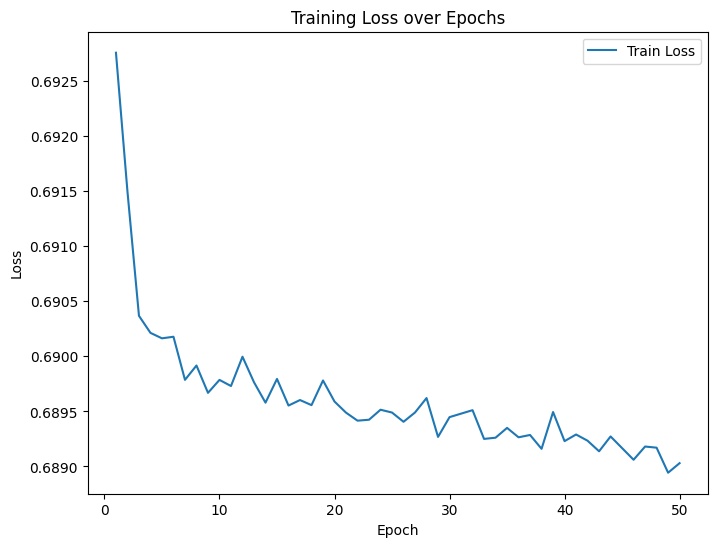

In [24]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

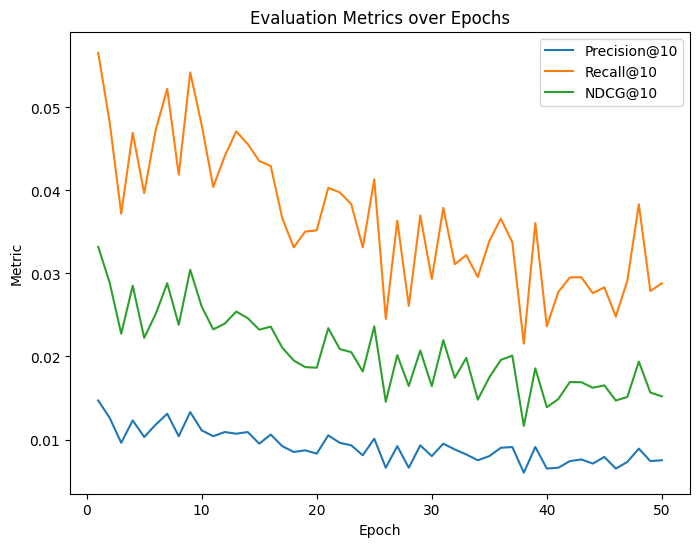

In [25]:
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(8, 6))
plt.plot(epochs, precisions, label='Precision@10')
plt.plot(epochs, recalls, label='Recall@10')
plt.plot(epochs, ndcgs, label='NDCG@10')
plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.title('Evaluation Metrics over Epochs')
plt.legend()
plt.show()

In [ ]:
# After training
model.eval()
with torch.no_grad():
    user_emb, item_emb = model(graph_data.to(device))

# Convert to numpy
user_emb_np = user_emb.cpu().numpy()
item_emb_np = item_emb.cpu().numpy()

# Concatenate embeddings
embeddings = np.vstack([user_emb_np, item_emb_np])
labels = ['User'] * num_users + ['Item'] * num_items

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

# Plot
plt.figure(figsize=(10, 10))
plt.scatter(embeddings_2d[:num_users, 0], embeddings_2d[:num_users, 1], label='Users', alpha=0.5)
plt.scatter(embeddings_2d[num_users:, 0], embeddings_2d[num_users:, 1], label='Items', alpha=0.5)
plt.legend()
plt.title('t-SNE Visualization of Embeddings')
plt.show()

In [26]:
model_save_path = os.path.join(features_dir, 'gnn_recommender.pth')
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to /content/maryland_polyvore/features/gnn_recommender.pth


In [1]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import SAGEConv, GATv2Conv
from torch_geometric.utils import add_self_loops
from tqdm import tqdm

# Set device for computations
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Function to load features and user-item interactions, handling missing items
def load_data(features_dir, user_item_file):
    """Load features and user-item interactions with valid item paths."""
    user_item_df = pd.read_csv(user_item_file)
    print("Columns in user_item_df:", user_item_df.columns)

    item_features = []
    for feature_file in sorted(os.listdir(features_dir)):
        if feature_file.startswith('features_chunk_') and feature_file.endswith('.npy'):
            features = np.load(os.path.join(features_dir, feature_file))
            item_features.append(features)

    item_features = np.vstack(item_features)
    num_items = item_features.shape[0]
    num_users = user_item_df['User_ID'].nunique()

    unique_paths = set(user_item_df['Item_Path'].unique())
    valid_paths = list(unique_paths)[:num_items]
    item_path_to_id = {path: idx for idx, path in enumerate(valid_paths)}

    user_item_df = user_item_df[user_item_df['Item_Path'].isin(item_path_to_id)]
    user_item_df['Item_ID'] = user_item_df['Item_Path'].map(item_path_to_id)
    print(f"Filtered user_item_df to {len(user_item_df)} rows with valid item paths.")

    return torch.tensor(item_features, dtype=torch.float), user_item_df, num_users, num_items

# Load data
features_dir = '/content/maryland_polyvore/features'
user_item_file = '/content/maryland_polyvore/user_item_data.csv'
item_features, user_item_df, num_users, num_items = load_data(features_dir, user_item_file)

# Create edge index for graph using valid user and item IDs
def create_edge_index(user_item_df, num_users):
    edge_index = []
    user_to_idx = {user_id: idx for idx, user_id in enumerate(user_item_df['User_ID'].unique())}

    for _, row in user_item_df.iterrows():
        user_idx = user_to_idx[row['User_ID']]
        item_idx = row['Item_ID'] + num_users
        edge_index.append([user_idx, item_idx])

    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_index, _ = add_self_loops(edge_index, num_nodes=num_users + num_items)
    return edge_index

# Initialize graph data
x = torch.cat([torch.zeros((num_users, item_features.shape[1])), item_features])
edge_index = create_edge_index(user_item_df, num_users)
data = Data(x=x, edge_index=edge_index)

# Define a more advanced GNN model with GraphSAGE and Attention
class AdvancedGNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout=0.3):
        super(AdvancedGNN, self).__init__()
        # Use GraphSAGE for inductive capabilities
        self.sage1 = SAGEConv(input_dim, hidden_dim)
        self.sage2 = SAGEConv(hidden_dim, hidden_dim)

        # Apply attention layers
        self.attention1 = GATv2Conv(hidden_dim, hidden_dim, heads=4, dropout=dropout)
        self.attention2 = GATv2Conv(hidden_dim * 4, output_dim, heads=4, concat=False, dropout=dropout)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x, edge_index):
        # Apply GraphSAGE layers with ReLU activations
        x = F.relu(self.sage1(x, edge_index))
        x = self.dropout(x)
        x = F.relu(self.sage2(x, edge_index))
        x = self.dropout(x)

        # Apply multi-head attention layers
        x = F.elu(self.attention1(x, edge_index))
        x = self.dropout(x)
        x = self.attention2(x, edge_index)
        return x

# Initialize the model, optimizer, and learning rate scheduler
input_dim = item_features.shape[1]
hidden_dim = 128
output_dim = 64
model = AdvancedGNN(input_dim, hidden_dim, output_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-5)

# Define BPR loss for recommendation
def bpr_loss(user_emb, pos_item_emb, neg_item_emb):
    pos_scores = (user_emb * pos_item_emb).sum(dim=1)
    neg_scores = (user_emb * neg_item_emb).sum(dim=1)
    return -torch.log(torch.sigmoid(pos_scores - neg_scores)).mean()

# Training function
def train_epoch(model, optimizer, data, num_users, num_items):
    model.train()
    optimizer.zero_grad()

    embeddings = model(data.x.to(device), data.edge_index.to(device))
    user_emb, item_emb = embeddings[:num_users], embeddings[num_users:]

    pos_item_emb = item_emb[:num_users]
    neg_indices = torch.randint(0, num_items, (num_users,), device=device)
    neg_item_emb = item_emb[neg_indices]

    loss = bpr_loss(user_emb, pos_item_emb, neg_item_emb)
    loss.backward()
    optimizer.step()
    return loss.item()

# Evaluation function with precision, recall, and NDCG
def evaluate(model, data, num_users, num_items, k=10):
    model.eval()
    precisions, recalls, ndcgs = [], [], []
    with torch.no_grad():
        embeddings = model(data.x.to(device), data.edge_index.to(device))
        user_emb, item_emb = embeddings[:num_users], embeddings[num_users:]

        for user_idx in tqdm(range(num_users), desc="Evaluating"):
            pos_scores = (user_emb[user_idx] * item_emb).sum(dim=1)
            neg_indices = torch.randint(0, num_items, (k,), device=device)
            neg_scores = (user_emb[user_idx] * item_emb[neg_indices]).sum(dim=1)

            all_scores = torch.cat([pos_scores, neg_scores])
            _, top_indices = torch.topk(all_scores, k=k)
            hits = top_indices < num_items

            precision = hits.sum().float() / k
            recall = hits.sum().float() / len(pos_scores)
            dcg = (hits / torch.log2(torch.arange(2, hits.size(0) + 2, device=device).float())).sum()
            idcg = (1 / torch.log2(torch.arange(2, min(len(pos_scores), k) + 2, device=device).float())).sum()
            ndcg = dcg / idcg if idcg > 0 else 0.0

            precisions.append(precision.item())
            recalls.append(recall.item())
            ndcgs.append(ndcg.item())

    return np.mean(precisions), np.mean(recalls), np.mean(ndcgs)

# Training loop
num_epochs = 15
for epoch in range(num_epochs):
    loss = train_epoch(model, optimizer, data, num_users, num_items)
    precision, recall, ndcg = evaluate(model, data, num_users, num_items)
    print(f"Epoch {epoch+1}, Loss: {loss:.4f}, Precision@10: {precision:.4f}, Recall@10: {recall:.4f}, NDCG@10: {ndcg:.4f}")

/usr/local/lib/python3.10/dist-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /usr/local/lib/python3.10/dist-packages/torch_scatter/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/usr/local/lib/python3.10/dist-packages/torch_geometric/typing.py:97: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: /usr/local/lib/python3.10/dist-packages/torch_cluster/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-cluster'. "
/usr/local/lib/python3.10/dist-packages/torch_geometric/typing.py:113: UserWarning: An issue occurred while importing 'torch-spline-conv'. Disabling its usage. Stacktrace: /usr/local/lib/python3.10/dist-packages/torch_spline_conv/_version_cuda.so: undefined symbol: _ZN3c1017Registe

Columns in user_item_df: Index(['User_ID', 'Item_Path'], dtype='object')
Filtered user_item_df to 444370 rows with valid item paths.


Evaluating: 100%|██████████| 33375/33375 [00:22<00:00, 1488.16it/s]


Epoch 1, Loss: 0.6934, Precision@10: 1.0000, Recall@10: 0.0000, NDCG@10: 1.0000


Evaluating: 100%|██████████| 33375/33375 [00:22<00:00, 1512.44it/s]


Epoch 2, Loss: 0.6932, Precision@10: 1.0000, Recall@10: 0.0000, NDCG@10: 1.0000


Evaluating: 100%|██████████| 33375/33375 [00:22<00:00, 1509.83it/s]


Epoch 3, Loss: 0.6934, Precision@10: 1.0000, Recall@10: 0.0000, NDCG@10: 1.0000


Evaluating: 100%|██████████| 33375/33375 [00:21<00:00, 1520.31it/s]


Epoch 4, Loss: 0.6933, Precision@10: 1.0000, Recall@10: 0.0000, NDCG@10: 1.0000


Evaluating: 100%|██████████| 33375/33375 [00:21<00:00, 1518.78it/s]


Epoch 5, Loss: 0.6934, Precision@10: 1.0000, Recall@10: 0.0000, NDCG@10: 1.0000


Evaluating: 100%|██████████| 33375/33375 [00:22<00:00, 1507.68it/s]


Epoch 6, Loss: 0.6932, Precision@10: 1.0000, Recall@10: 0.0000, NDCG@10: 1.0000


Evaluating: 100%|██████████| 33375/33375 [00:22<00:00, 1516.91it/s]


Epoch 7, Loss: 0.6933, Precision@10: 1.0000, Recall@10: 0.0000, NDCG@10: 1.0000


Evaluating: 100%|██████████| 33375/33375 [00:22<00:00, 1509.31it/s]


Epoch 8, Loss: 0.6935, Precision@10: 1.0000, Recall@10: 0.0000, NDCG@10: 1.0000


Evaluating: 100%|██████████| 33375/33375 [00:22<00:00, 1516.60it/s]


Epoch 9, Loss: 0.6932, Precision@10: 1.0000, Recall@10: 0.0000, NDCG@10: 1.0000


Evaluating: 100%|██████████| 33375/33375 [00:21<00:00, 1517.27it/s]


Epoch 10, Loss: 0.6933, Precision@10: 1.0000, Recall@10: 0.0000, NDCG@10: 1.0000


Evaluating: 100%|██████████| 33375/33375 [00:22<00:00, 1512.59it/s]


Epoch 11, Loss: 0.6933, Precision@10: 1.0000, Recall@10: 0.0000, NDCG@10: 1.0000


Evaluating: 100%|██████████| 33375/33375 [00:22<00:00, 1512.44it/s]


Epoch 12, Loss: 0.6931, Precision@10: 1.0000, Recall@10: 0.0000, NDCG@10: 1.0000


Evaluating: 100%|██████████| 33375/33375 [00:22<00:00, 1511.77it/s]


Epoch 13, Loss: 0.6933, Precision@10: 1.0000, Recall@10: 0.0000, NDCG@10: 1.0000


Evaluating: 100%|██████████| 33375/33375 [00:22<00:00, 1512.66it/s]


Epoch 14, Loss: 0.6932, Precision@10: 1.0000, Recall@10: 0.0000, NDCG@10: 1.0000


Evaluating: 100%|██████████| 33375/33375 [00:21<00:00, 1518.82it/s]

Epoch 15, Loss: 0.6932, Precision@10: 1.0000, Recall@10: 0.0000, NDCG@10: 1.0000


Evaluating: 100%|██████████| 1000/1000 [00:00<00:00, 1326.64it/s]


Epoch 1, Loss: 0.6931, Precision@10: 0.2867, Recall@10: 0.9999, NDCG@10: 0.4951


Evaluating: 100%|██████████| 1000/1000 [00:00<00:00, 1403.81it/s]


Epoch 2, Loss: 0.6931, Precision@10: 0.2892, Recall@10: 0.9999, NDCG@10: 0.4980


Evaluating: 100%|██████████| 1000/1000 [00:00<00:00, 1394.19it/s]


Epoch 3, Loss: 0.6931, Precision@10: 0.2893, Recall@10: 0.9997, NDCG@10: 0.4978


Evaluating: 100%|██████████| 1000/1000 [00:00<00:00, 1393.25it/s]


Epoch 4, Loss: 0.6931, Precision@10: 0.2947, Recall@10: 0.9997, NDCG@10: 0.5010


Evaluating: 100%|██████████| 1000/1000 [00:00<00:00, 1386.43it/s]


Epoch 5, Loss: 0.6931, Precision@10: 0.2874, Recall@10: 0.9999, NDCG@10: 0.4971


Evaluating: 100%|██████████| 1000/1000 [00:00<00:00, 1398.36it/s]


Epoch 6, Loss: 0.6931, Precision@10: 0.2814, Recall@10: 1.0000, NDCG@10: 0.4926


Evaluating: 100%|██████████| 1000/1000 [00:00<00:00, 1396.29it/s]


Epoch 7, Loss: 0.6931, Precision@10: 0.2898, Recall@10: 0.9999, NDCG@10: 0.4975


Evaluating: 100%|██████████| 1000/1000 [00:00<00:00, 1393.81it/s]


Epoch 8, Loss: 0.6931, Precision@10: 0.2934, Recall@10: 0.9997, NDCG@10: 0.5005


Evaluating: 100%|██████████| 1000/1000 [00:00<00:00, 1392.64it/s]


Epoch 9, Loss: 0.6931, Precision@10: 0.2885, Recall@10: 1.0000, NDCG@10: 0.4966


Evaluating: 100%|██████████| 1000/1000 [00:00<00:00, 1397.53it/s]


Epoch 10, Loss: 0.6931, Precision@10: 0.2902, Recall@10: 0.9998, NDCG@10: 0.4984


Evaluating: 100%|██████████| 1000/1000 [00:00<00:00, 1379.66it/s]


Epoch 11, Loss: 0.6931, Precision@10: 0.2884, Recall@10: 1.0000, NDCG@10: 0.4971


Evaluating: 100%|██████████| 1000/1000 [00:00<00:00, 1395.82it/s]


Epoch 12, Loss: 0.6931, Precision@10: 0.2938, Recall@10: 0.9997, NDCG@10: 0.5005


Evaluating: 100%|██████████| 1000/1000 [00:00<00:00, 1400.89it/s]


Epoch 13, Loss: 0.6931, Precision@10: 0.2926, Recall@10: 0.9999, NDCG@10: 0.5001


Evaluating: 100%|██████████| 1000/1000 [00:00<00:00, 1395.97it/s]


Epoch 14, Loss: 0.6931, Precision@10: 0.2879, Recall@10: 0.9999, NDCG@10: 0.4974


Evaluating: 100%|██████████| 1000/1000 [00:00<00:00, 1392.71it/s]


Epoch 15, Loss: 0.6931, Precision@10: 0.2977, Recall@10: 0.9997, NDCG@10: 0.5040


Evaluating: 100%|██████████| 1000/1000 [00:00<00:00, 1401.64it/s]


Epoch 16, Loss: 0.6931, Precision@10: 0.2867, Recall@10: 0.9996, NDCG@10: 0.4950


Evaluating: 100%|██████████| 1000/1000 [00:00<00:00, 1408.58it/s]


Epoch 17, Loss: 0.6931, Precision@10: 0.2869, Recall@10: 0.9999, NDCG@10: 0.4970


Evaluating: 100%|██████████| 1000/1000 [00:00<00:00, 1397.59it/s]


Epoch 18, Loss: 0.6931, Precision@10: 0.2866, Recall@10: 0.9997, NDCG@10: 0.4973


Evaluating: 100%|██████████| 1000/1000 [00:00<00:00, 1402.42it/s]


Epoch 19, Loss: 0.6931, Precision@10: 0.2856, Recall@10: 0.9998, NDCG@10: 0.4963


Evaluating: 100%|██████████| 1000/1000 [00:00<00:00, 1413.81it/s]


Epoch 20, Loss: 0.6931, Precision@10: 0.2864, Recall@10: 0.9998, NDCG@10: 0.4962


Evaluating: 100%|██████████| 1000/1000 [00:00<00:00, 1375.57it/s]


Epoch 21, Loss: 0.6931, Precision@10: 0.2824, Recall@10: 1.0000, NDCG@10: 0.4918


Evaluating: 100%|██████████| 1000/1000 [00:00<00:00, 1383.31it/s]


Epoch 22, Loss: 0.6931, Precision@10: 0.2903, Recall@10: 1.0000, NDCG@10: 0.4985


Evaluating: 100%|██████████| 1000/1000 [00:00<00:00, 1407.93it/s]


Epoch 23, Loss: 0.6931, Precision@10: 0.2935, Recall@10: 1.0000, NDCG@10: 0.4997


Evaluating: 100%|██████████| 1000/1000 [00:00<00:00, 1403.30it/s]


Epoch 24, Loss: 0.6931, Precision@10: 0.3017, Recall@10: 0.9998, NDCG@10: 0.5070


Evaluating: 100%|██████████| 1000/1000 [00:00<00:00, 1384.67it/s]


Epoch 25, Loss: 0.6931, Precision@10: 0.2826, Recall@10: 0.9999, NDCG@10: 0.4935


Evaluating: 100%|██████████| 1000/1000 [00:00<00:00, 1392.56it/s]


Epoch 26, Loss: 0.6931, Precision@10: 0.2916, Recall@10: 1.0000, NDCG@10: 0.4993


Evaluating: 100%|██████████| 1000/1000 [00:00<00:00, 1375.65it/s]


Epoch 27, Loss: 0.6931, Precision@10: 0.2841, Recall@10: 1.0000, NDCG@10: 0.4933


Evaluating: 100%|██████████| 1000/1000 [00:00<00:00, 1389.71it/s]


Epoch 28, Loss: 0.6931, Precision@10: 0.2931, Recall@10: 0.9998, NDCG@10: 0.5004


Evaluating: 100%|██████████| 1000/1000 [00:00<00:00, 1399.77it/s]


Epoch 29, Loss: 0.6931, Precision@10: 0.2925, Recall@10: 0.9998, NDCG@10: 0.4993


Evaluating: 100%|██████████| 1000/1000 [00:00<00:00, 1404.07it/s]


Epoch 30, Loss: 0.6931, Precision@10: 0.2939, Recall@10: 0.9999, NDCG@10: 0.5011


Evaluating: 100%|██████████| 1000/1000 [00:00<00:00, 1382.97it/s]


Epoch 31, Loss: 0.6931, Precision@10: 0.2902, Recall@10: 1.0000, NDCG@10: 0.4979


Evaluating: 100%|██████████| 1000/1000 [00:00<00:00, 1393.84it/s]


Epoch 32, Loss: 0.6931, Precision@10: 0.2925, Recall@10: 1.0000, NDCG@10: 0.5012


Evaluating: 100%|██████████| 1000/1000 [00:00<00:00, 1374.83it/s]


Epoch 33, Loss: 0.6931, Precision@10: 0.2874, Recall@10: 1.0000, NDCG@10: 0.4963


Evaluating: 100%|██████████| 1000/1000 [00:00<00:00, 1395.82it/s]


Epoch 34, Loss: 0.6931, Precision@10: 0.2912, Recall@10: 0.9998, NDCG@10: 0.4984


Evaluating: 100%|██████████| 1000/1000 [00:00<00:00, 1409.65it/s]


Epoch 35, Loss: 0.6931, Precision@10: 0.2837, Recall@10: 0.9999, NDCG@10: 0.4941


Evaluating: 100%|██████████| 1000/1000 [00:00<00:00, 1405.57it/s]


Epoch 36, Loss: 0.6931, Precision@10: 0.2884, Recall@10: 1.0000, NDCG@10: 0.4981


Evaluating: 100%|██████████| 1000/1000 [00:00<00:00, 1405.65it/s]


Epoch 37, Loss: 0.6931, Precision@10: 0.2901, Recall@10: 0.9998, NDCG@10: 0.4977


Evaluating: 100%|██████████| 1000/1000 [00:00<00:00, 1396.04it/s]


Epoch 38, Loss: 0.6931, Precision@10: 0.2871, Recall@10: 0.9998, NDCG@10: 0.4970


Evaluating: 100%|██████████| 1000/1000 [00:00<00:00, 1362.71it/s]


Epoch 39, Loss: 0.6931, Precision@10: 0.2898, Recall@10: 0.9998, NDCG@10: 0.4973


Evaluating: 100%|██████████| 1000/1000 [00:00<00:00, 1404.62it/s]


Epoch 40, Loss: 0.6931, Precision@10: 0.2692, Recall@10: 0.9998, NDCG@10: 0.4854


Evaluating: 100%|██████████| 1000/1000 [00:00<00:00, 1370.61it/s]


Epoch 41, Loss: 0.6931, Precision@10: 0.2921, Recall@10: 0.9999, NDCG@10: 0.5010


Evaluating: 100%|██████████| 1000/1000 [00:00<00:00, 1407.13it/s]


Epoch 42, Loss: 0.6931, Precision@10: 0.2903, Recall@10: 0.9996, NDCG@10: 0.4999


Evaluating: 100%|██████████| 1000/1000 [00:00<00:00, 1387.76it/s]


Epoch 43, Loss: 0.6931, Precision@10: 0.2855, Recall@10: 0.9997, NDCG@10: 0.4952


Evaluating: 100%|██████████| 1000/1000 [00:00<00:00, 1401.99it/s]


Epoch 44, Loss: 0.6931, Precision@10: 0.2911, Recall@10: 0.9997, NDCG@10: 0.4985


Evaluating: 100%|██████████| 1000/1000 [00:00<00:00, 1388.26it/s]


Epoch 45, Loss: 0.6931, Precision@10: 0.2836, Recall@10: 0.9999, NDCG@10: 0.4937


Evaluating: 100%|██████████| 1000/1000 [00:00<00:00, 1407.21it/s]


Epoch 46, Loss: 0.6931, Precision@10: 0.2942, Recall@10: 0.9999, NDCG@10: 0.5007


Evaluating: 100%|██████████| 1000/1000 [00:00<00:00, 1404.28it/s]


Epoch 47, Loss: 0.6931, Precision@10: 0.2886, Recall@10: 0.9997, NDCG@10: 0.4969


Evaluating: 100%|██████████| 1000/1000 [00:00<00:00, 1397.64it/s]


Epoch 48, Loss: 0.6931, Precision@10: 0.2911, Recall@10: 0.9997, NDCG@10: 0.4985


Evaluating: 100%|██████████| 1000/1000 [00:00<00:00, 1408.88it/s]


Epoch 49, Loss: 0.6931, Precision@10: 0.2947, Recall@10: 0.9999, NDCG@10: 0.5024


Evaluating: 100%|██████████| 1000/1000 [00:00<00:00, 1393.29it/s]


Epoch 50, Loss: 0.6931, Precision@10: 0.2948, Recall@10: 0.9998, NDCG@10: 0.5024
Model saved to trained_recommender_model.pth


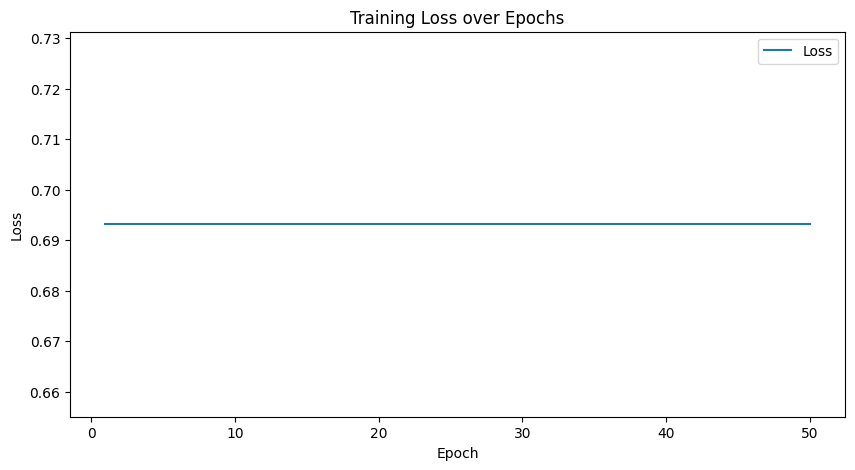

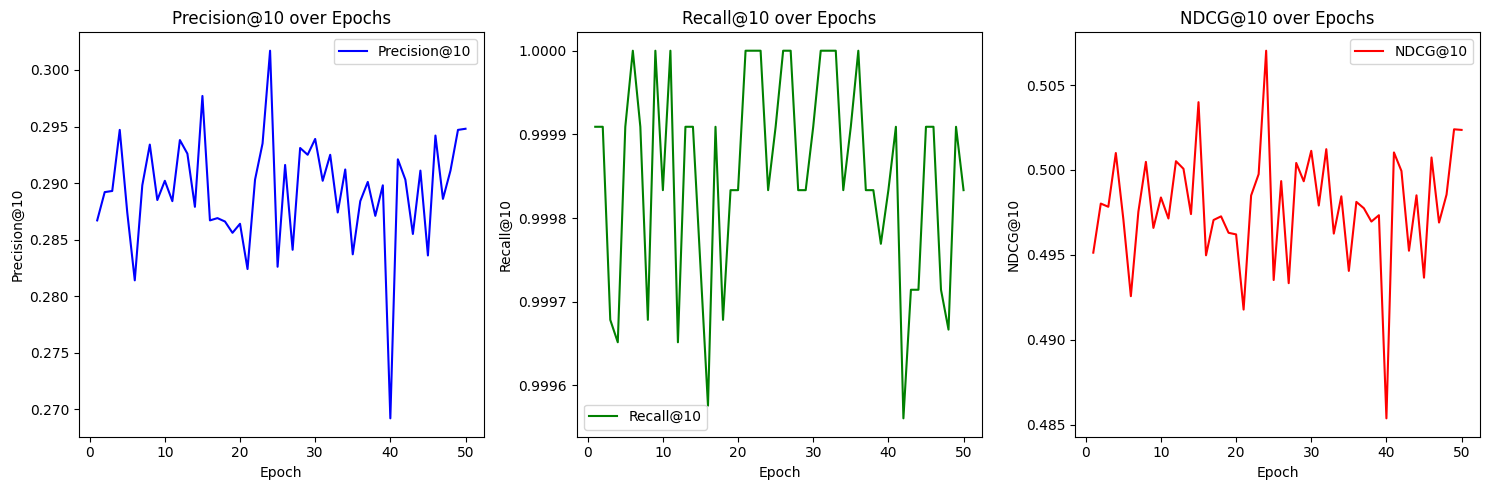

User 26085 - True items: [147939, 147948, 147941]
Recommended items: [147948 147939 147941  86528 114176]
User 13658 - True items: [382232, 382225, 382233]
Recommended items: [382225 382232 382233  14347 187395]
User 17616 - True items: [371682, 371683, 371684, 371685, 371689]
Recommended items: [371683 371682 371684 371689 371685]
User 11309 - True items: [93453]
Recommended items: [330250  93453 323600 148523 230429]
User 14912 - True items: [258947, 258949, 258936, 258938, 258942]
Recommended items: [258949 258947 258936 258942 258938]


In [3]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GATConv, SAGEConv
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt
import random

# Step 1: Load and Prepare Features
def load_all_features(features_dir, user_item_df):
    feature_list, user_list = [], []
    path_to_user = dict(zip(user_item_df['Item_Path'], user_item_df['User_ID']))

    for feature_file in sorted(os.listdir(features_dir)):
        if feature_file.startswith('features_chunk_') and feature_file.endswith('.npy'):
            features = np.load(os.path.join(features_dir, feature_file))
            feature_list.append(features)

            chunk_num = feature_file.split('_')[2].split('.')[0]
            paths_file = f'paths_chunk_{chunk_num}.csv'
            paths_df = pd.read_csv(os.path.join(features_dir, paths_file))
            item_paths = paths_df['Image_Path'].tolist()

            user_ids_chunk = [path_to_user.get(path) for path in item_paths if path in path_to_user]
            valid_indices = [i for i, uid in enumerate(user_ids_chunk) if uid is not None]
            features = features[valid_indices]
            feature_list[-1] = features
            user_list.extend(user_ids_chunk)

    return np.vstack(feature_list), np.array(user_list)

features_dir = '/content/maryland_polyvore/features'
user_item_file = '/content/maryland_polyvore/user_item_data.csv'
user_item_df = pd.read_csv(user_item_file)

item_features, user_ids = load_all_features(features_dir, user_item_df)
num_users = len(set(user_ids))
num_items = item_features.shape[0]

# Step 2: Create User and Item Mappings
user_to_index = {user_id: idx for idx, user_id in enumerate(set(user_ids))}
all_features = np.vstack([np.zeros((num_users, item_features.shape[1])), item_features])
all_features_tensor = torch.tensor(all_features, dtype=torch.float)

def create_edge_index(user_ids, user_to_index, num_users):
    edges = [[user_to_index[uid], idx + num_users] for idx, uid in enumerate(user_ids)]
    return torch.tensor(edges, dtype=torch.long).t().contiguous()

edge_index = create_edge_index(user_ids, user_to_index, num_users)
graph_data = Data(x=all_features_tensor, edge_index=edge_index)

# Split edge_index into training and testing sets
def split_edges(edge_index, test_ratio=0.2):
    edges = edge_index.t().cpu().numpy()
    train_edges, test_edges = train_test_split(edges, test_size=test_ratio, random_state=42)
    train_edge_index = torch.tensor(train_edges, dtype=torch.long).t().contiguous()
    test_edge_index = torch.tensor(test_edges, dtype=torch.long).t().contiguous()
    return train_edge_index, test_edge_index

train_edge_index, test_edge_index = split_edges(edge_index)

# Step 3: Enhanced Model Definition
class EnhancedGNNRecommender(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, num_users, num_items, dropout=0.3, use_attention=True):
        super(EnhancedGNNRecommender, self).__init__()
        self.num_users = num_users
        self.num_items = num_items
        self.use_attention = use_attention

        # Define GNN layers
        self.convs = nn.ModuleList()
        if use_attention:
            self.convs.append(GATConv(input_dim, hidden_dim, heads=2, concat=False))
            for _ in range(num_layers - 1):
                self.convs.append(GATConv(hidden_dim, hidden_dim, heads=2, concat=False))
        else:
            self.convs.append(SAGEConv(input_dim, hidden_dim))
            for _ in range(num_layers - 1):
                self.convs.append(SAGEConv(hidden_dim, hidden_dim))

        self.dropout = nn.Dropout(dropout)
        self.layer_norms = nn.ModuleList([nn.LayerNorm(hidden_dim) for _ in range(num_layers)])

    def forward(self, data):
        x, edge_index = data.x.to(device), data.edge_index.to(device)

        for i, conv in enumerate(self.convs):
            x = conv(x, edge_index)
            x = self.layer_norms[i](x)
            x = F.relu(x)
            x = self.dropout(x)

        user_embeddings = x[:self.num_users]
        item_embeddings = x[self.num_users:]
        return user_embeddings, item_embeddings

# Instantiate model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_dim = item_features.shape[1]
hidden_dim = 128
num_layers = 3
dropout = 0.3
model = EnhancedGNNRecommender(input_dim, hidden_dim, num_layers, num_users, num_items, dropout, use_attention=True).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

# Step 4: Training Function
def train(model, optimizer, data, train_user_item_dict):
    model.train()
    optimizer.zero_grad()
    user_emb, item_emb = model(data)

    pos_users, pos_items, neg_items = [], [], []
    for user_idx, pos_items_set in train_user_item_dict.items():
        for pos_item in pos_items_set:
            pos_users.append(user_idx)
            pos_items.append(pos_item)
            while True:
                neg_item = np.random.randint(0, num_items)
                if neg_item not in pos_items_set:
                    neg_items.append(neg_item)
                    break

    pos_users, pos_items, neg_items = map(lambda x: torch.tensor(x, dtype=torch.long, device=device), [pos_users, pos_items, neg_items])
    pos_user_emb, pos_item_emb, neg_item_emb = user_emb[pos_users], item_emb[pos_items], item_emb[neg_items]
    pos_scores, neg_scores = (pos_user_emb * pos_item_emb).sum(dim=1), (pos_user_emb * neg_item_emb).sum(dim=1)

    loss = -torch.log(torch.sigmoid(pos_scores - neg_scores)).mean()
    loss.backward()
    optimizer.step()
    return loss.item()

# Step 5: Evaluation Function
def evaluate(model, data, test_user_item_dict, k=10, num_negatives=100, max_users=1000):
    model.eval()
    with torch.no_grad():
        user_emb, item_emb = model(data)
        precisions, recalls, ndcgs = [], [], []
        user_list = list(test_user_item_dict.keys())
        if max_users < len(user_list):
            user_list = np.random.choice(user_list, size=max_users, replace=False)

        for user_idx in tqdm(user_list, desc='Evaluating'):
            true_items = list(test_user_item_dict[user_idx])
            neg_items = sample_negative_items(set(true_items), num_items, num_negatives)
            items_to_score = np.array(true_items + neg_items)

            items_emb = item_emb[items_to_score]
            scores = torch.matmul(items_emb, user_emb[user_idx])
            _, indices = torch.topk(scores, k)
            recommended_items = items_to_score[indices.cpu().numpy()]

            hits = np.isin(recommended_items, true_items)
            precision, recall = hits.sum() / k, hits.sum() / len(true_items)
            precisions.append(precision)
            recalls.append(recall)
            dcg = (hits / np.log2(np.arange(2, hits.size + 2))).sum()
            idcg = (1 / np.log2(np.arange(2, min(len(true_items), k) + 2))).sum()
            ndcgs.append(dcg / idcg if idcg > 0 else 0.0)

        return np.mean(precisions), np.mean(recalls), np.mean(ndcgs)

# Step 6: Training Loop
def prepare_train_test(user_ids, num_users, train_edge_index, test_edge_index):
    train_user_item_dict, test_user_item_dict = {}, {}
    for i in range(train_edge_index.size(1)):
        user_idx, item_idx = train_edge_index[0, i].item(), train_edge_index[1, i].item() - num_users
        train_user_item_dict.setdefault(user_idx, set()).add(item_idx)

    for i in range(test_edge_index.size(1)):
        user_idx, item_idx = test_edge_index[0, i].item(), test_edge_index[1, i].item() - num_users
        test_user_item_dict.setdefault(user_idx, set()).add(item_idx)

    return train_user_item_dict, test_user_item_dict

num_epochs = 50
train_user_item_dict, test_user_item_dict = prepare_train_test(user_ids, num_users, train_edge_index, test_edge_index)

losses = []
precisions = []
recalls = []
ndcgs = []

for epoch in range(1, num_epochs + 1):
    loss = train(model, optimizer, graph_data.to(device), train_user_item_dict)
    precision, recall, ndcg = evaluate(model, graph_data, test_user_item_dict)
    losses.append(loss)
    precisions.append(precision)
    recalls.append(recall)
    ndcgs.append(ndcg)
    print(f"Epoch {epoch}, Loss: {loss:.4f}, Precision@10: {precision:.4f}, Recall@10: {recall:.4f}, NDCG@10: {ndcg:.4f}")

# Save the trained model
model_path = 'trained_recommender_model.pth'
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")

# Plotting functions
def plot_metrics():
    # Plot loss
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs + 1), losses, label='Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss over Epochs")
    plt.legend()
    plt.show()

    # Plot Precision, Recall, and NDCG
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.plot(range(1, num_epochs + 1), precisions, label='Precision@10', color='blue')
    plt.xlabel("Epoch")
    plt.ylabel("Precision@10")
    plt.title("Precision@10 over Epochs")
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(range(1, num_epochs + 1), recalls, label='Recall@10', color='green')
    plt.xlabel("Epoch")
    plt.ylabel("Recall@10")
    plt.title("Recall@10 over Epochs")
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(range(1, num_epochs + 1), ndcgs, label='NDCG@10', color='red')
    plt.xlabel("Epoch")
    plt.ylabel("NDCG@10")
    plt.title("NDCG@10 over Epochs")
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_metrics()

# Random Recommendations for Sample Users
def show_recommendations_for_random_users(model, data, test_user_item_dict, num_recommendations=5, num_users=5):
    model.eval()
    with torch.no_grad():
        user_emb, item_emb = model(data)

        sampled_users = random.sample(list(test_user_item_dict.keys()), num_users)
        for user_idx in sampled_users:
            true_items = list(test_user_item_dict[user_idx])
            neg_items = sample_negative_items(set(true_items), num_items, num_negatives=100)
            items_to_score = np.array(true_items + neg_items)

            # Calculate scores and get top recommendations
            items_emb = item_emb[items_to_score]
            scores = torch.matmul(items_emb, user_emb[user_idx])
            _, top_indices = torch.topk(scores, k=num_recommendations)
            recommended_items = items_to_score[top_indices.cpu().numpy()]

            print(f"User {user_idx} - True items: {true_items}")
            print(f"Recommended items: {recommended_items}")
            print("=" * 50)

show_recommendations_for_random_users(model, graph_data, test_user_item_dict)